In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy import signal
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
from tqdm import tqdm

import sys
sys.path.append('/Users/ag1880/Github_repos/Milstein-Lab/dentate_circuit_model/')
from optimize_dynamic_model import get_binary_input_patterns

%matplotlib inline

In [2]:
class dentate_network(nn.Module):
    def __init__(self, lr):
        self.lr = lr
        self.input_size = 7
        self.output_size = 128
        
        super().__init__()

        self.net = nn.Sequential(nn.Linear(self.input_size, self.output_size),)
                
        self.optimizer = torch.optim.SGD(self.net.parameters(), lr=lr)
        
        
    def forward(self, input_pattern):
        output = self.net(input_pattern)
        output = F.sigmoid(output)
        return F.softmax(output)

    def forward_activation(self, input_pattern):
        output = self.net(input_pattern)
        return F.sigmoid(output)
    
    def forward_linear(self, input_pattern):
        output = self.net(input_pattern)
        return output
    
    
    def train(self,epochs,all_patterns):
        losses = []
        for i in tqdm(range(epochs)):
            self.optimizer.zero_grad()
            
            pattern_index = np.random.randint(0,128)
            input_pattern = all_patterns[pattern_index]
            
            output = self.forward(input_pattern)
            target = torch.eye(128)[pattern_index]
            
            non_target_idx = [x for x in range(128) if x!=pattern_index]
            non_target_loss = -torch.sum(torch.log(1-output[non_target_idx]))
            target_loss = -torch.log(output[pattern_index])
            loss = target_loss + non_target_loss
                            
            losses.append(loss.detach())
            loss.backward()
            self.optimizer.step()
            
        return losses

In [3]:
# Create network
dentate_net = dentate_network(lr=10)
all_patterns = torch.tensor(get_binary_input_patterns(7)).type(torch.float32)

In [4]:
# Save initial state
w_init = dentate_net.net[0].weight.detach().numpy().flatten()
b_init = dentate_net.net[0].bias.detach().numpy().flatten()

output_init = []
for pattern in all_patterns:
    output_init.append(list(dentate_net.forward_activation(pattern).detach()))
output_init = np.array(output_init)

In [5]:
# Train network
epochs = 2*10**5
losses = dentate_net.train(epochs, all_patterns)

100%|██████████| 200000/200000 [00:43<00:00, 4584.20it/s]


In [6]:
w_final = dentate_net.net[0].weight.detach().numpy().flatten()
b_final = dentate_net.net[0].bias.detach().numpy().flatten()

output_final_softmax = []
for pattern in all_patterns:
    output_final_softmax.append(list(dentate_net.forward(pattern).detach()))
output_final_softmax = np.array(output_final_softmax)

output_final_activation = []
for pattern in all_patterns:
    output_final_activation.append(list(dentate_net.forward_activation(pattern).detach()))
output_final_activation = np.array(output_final_activation)

output_final_linear = []
for pattern in all_patterns:
    output_final_linear.append(list(dentate_net.forward_linear(pattern).detach()))
output_final_linear = np.array(output_final_linear)

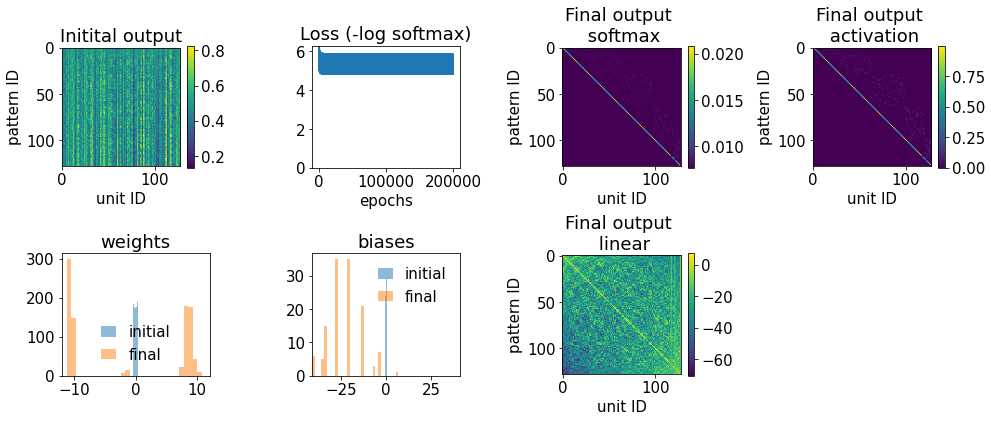

In [7]:
matplotlib.rcParams.update({'font.size': 15})

fig,ax = plt.subplots(nrows=2,ncols=4,figsize=(14,6))

im = ax[0,0].imshow(output_init)
ax[0,0].set_title('Initital output')
ax[0,0].set_xlabel('unit ID')
ax[0,0].set_ylabel('pattern ID')
cbar = plt.colorbar(im, ax=ax[0,0])

ax[0,1].plot(losses)
ax[0,1].set_xlabel('epochs')
ax[0,1].set_title('Loss (-log softmax)')
ax[0,1].set_ylim([0,np.max(losses)])

im = ax[0,2].imshow(output_final_softmax)
ax[0,2].set_title('Final output \n softmax')
ax[0,2].set_xlabel('unit ID')
ax[0,2].set_ylabel('pattern ID')
cbar = plt.colorbar(im, ax=ax[0,2])

im = ax[0,3].imshow(output_final_activation)
ax[0,3].set_title('Final output \n activation')
ax[0,3].set_xlabel('unit ID')
ax[0,3].set_ylabel('pattern ID')
cbar = plt.colorbar(im, ax=ax[0,3])

im = ax[1,2].imshow(output_final_linear)
ax[1,2].set_title('Final output \n linear')
ax[1,2].set_xlabel('unit ID')
ax[1,2].set_ylabel('pattern ID')
cbar = plt.colorbar(im, ax=ax[1,2])


ax[1,0].hist(w_init,5,alpha=0.5,label='initial')
ax[1,0].hist(w_final,30,alpha=0.5,label='final')
ax[1,0].set_title('weights')
ax[1,0].legend(loc='best', frameon=False,handlelength=1)
axis_range = np.ceil(np.abs(max(np.append(w_init,w_final), key=abs)))
ax[1,0].set_xlim([-axis_range,axis_range])


ax[1,1].hist(b_init,5,alpha=0.5,label='initial')
ax[1,1].hist(b_final,30,alpha=0.5,label='final')
ax[1,1].set_title('biases')
ax[1,1].legend(loc='best', frameon=False,handlelength=1)
axis_range = np.ceil(np.abs(max(np.append(b_init,b_final), key=abs)))
ax[1,1].set_xlim([-axis_range,axis_range])

ax[1,3].axis('off')

fig.tight_layout()
plt.show()

name = "backprop_network_CrossEntropyLossSoftmax_Sigmoid"
fig.savefig('../plots/'+name+'.png', edgecolor='white', dpi=300, facecolor='white', transparent=True)